# N2V Training Notebook

## Goal: improve signal to noise ratio in structured objects
Input: raw data/names of the files from a specific experiment

Output: trained model file (h5)


References:
1. https://github.com/juglab/n2v
2. https://github.com/juglab/n2v/blob/main/examples/2D/denoising2D_BSD68/BSD68_reproducibility.ipynb
3. https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/293_denoising_RGB_images_using_deep%20learning.ipynb

## Basic Setup
1. Import Tensorflow and check to make sure we are using GPU
2. Import N2V and dependencies

In [7]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
from PIL import Image
import random
import tifffile

In [9]:
from pycromanager import Dataset


## Reading in Data
Input: Raw data from a given experiment, which is a list of file names for the experiment

Select:
1. experiment date
2. experiment folder
3. filename base

Choose:
1. color channel

Output:
List of access indicies for all individial red channel images for the entire experiement

In [28]:
path = r"C:\Users\LevineLab\Documents\python notebooks\Wspa_EXPERIMENT_6_4_23"
exp_name = "StripA_cent1G_5h_jub39R_5h_6h_devA1_1"


exp_files  = [ "StripA_cent1G_5h_jub39R_5h_{}h_devA{}_1".format(tt,dd) for tt in range(6,12) for dd in range(1,5)]


In [24]:
print('this file has coresponds to a single time point and it has 2048^2 pixles per 4 channels per 9 z slices per 16 worms ')
Dataset(os.path.join(path,exp_files[0])).as_array()


this file has coresponds to a single time point and it has 2048^2 pixles per 4 channels per 9 z slices per 16 worms 
Dataset opened                


dask.array<read_one_image, shape=(4, 9, 16, 1, 2048, 2048), dtype=uint16, chunksize=(1, 1, 1, 1, 2048, 2048), chunktype=numpy.ndarray>

In [19]:
exp_files_red_keys = {exp:[d for d in Dataset(os.path.join(path,exp)).get_index_keys() if d['c'] ==3 ] for exp in exp_files}

red_images = []

for key, values in exp_files_red_keys.items():
    for value in values:
        new_dict = value.copy()  # create a copy of the dictionary
        new_dict["file"] = key  # add the new key-value pair
        red_images.append(new_dict)

print(f'found {len(red_images)} images in red channel')
red_images[:2]

Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
found 2376 images in red channel


[{'c': 3,
  'z': 0,
  'p': 0,
  'channel': 0,
  'file': 'StripA_cent1G_5h_jub39R_5h_6h_devA1_1'},
 {'c': 3,
  'p': 0,
  'channel': 0,
  'z': 1,
  'file': 'StripA_cent1G_5h_jub39R_5h_6h_devA1_1'}]

## Save a random subset of red images in seperate tiffs
We had memory issues when we tried to train too many images. We are randomly selecting some images here to be used in training. 

In [27]:
random_idx = random.sample(range(len(red_images)+1), 121)
exp_date = '5_5_23'

save_path = r"C:\Users\LevineLab\Documents\python notebooks\Wspa_EXPERIMENT_6_4_23\random_red_ims"

for j,i in enumerate(random_idx):
    image_path = os.path.join(path,red_images[i]['file'])
    dataset = Dataset(image_path)
    im = dataset.read_image(channel = 0,c = red_images[i]['c'],z = red_images[i]['z'], p=red_images[i]['p'])
    Image.fromarray(im).save(path+"/"+"random_red_ims/"+"im{}".format(j)+ ".tif")

Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                


Dataset opened                


Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                


Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                


Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                


Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                


Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                


Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                


Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                


Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                


Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                


Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                


Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                
Dataset opened                


## N2V patch generation
1. Load list of images
2. Display example image
3. Use N2V patch generator to generate patches

In [29]:
datagen = N2V_DataGenerator()
imgs = datagen.load_imgs_from_directory(directory = path+"/"+"random_red_ims/", filter="*.tif", dims="YX")


In [30]:
print(len(imgs))
print(imgs[0].shape)

121
(1, 2048, 2048, 1)


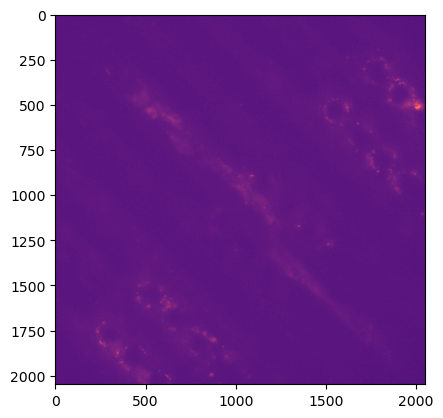

In [36]:
plt.imshow(imgs[2][0,...,0],cmap = 'magma')

### Selecting patch shape
1. Patch shape selected as 128x128 to give as large as possible perceptive field, objects in view are 5-30 pixels long, 56x256 was too large and netorwork had memory issues
2. patches_large is a list of all possible patches extracted from the images, with data augmentaiton
3. We have too many patches (memory issues) so we take a fraction (randomized) from the possible patches
4. Split into train and test using 1/8
5. Plot example patch

In [37]:
patch_shape = (128,128)
patches_large = datagen.generate_patches_from_list(imgs,shape = patch_shape,shuffle = True,augment=True)

Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048, 128, 128, 1)
Generated patches: (2048,

In [38]:
patches_large.shape

(247808, 128, 128, 1)

In [39]:
frac = 0.2
p_idx = [i for i in range(patches_large.shape[0]) if random.random() < frac]
patches = patches_large[p_idx,...]+0
del patches_large
patches.shape

(49749, 128, 128, 1)

In [40]:
patches.shape
divide = int(len(patches) / 8)
train_patches = patches[divide:]
val_patches = patches[:divide]
num_train = len(train_patches)
batch_size = 128 # training hyper param, this works okay

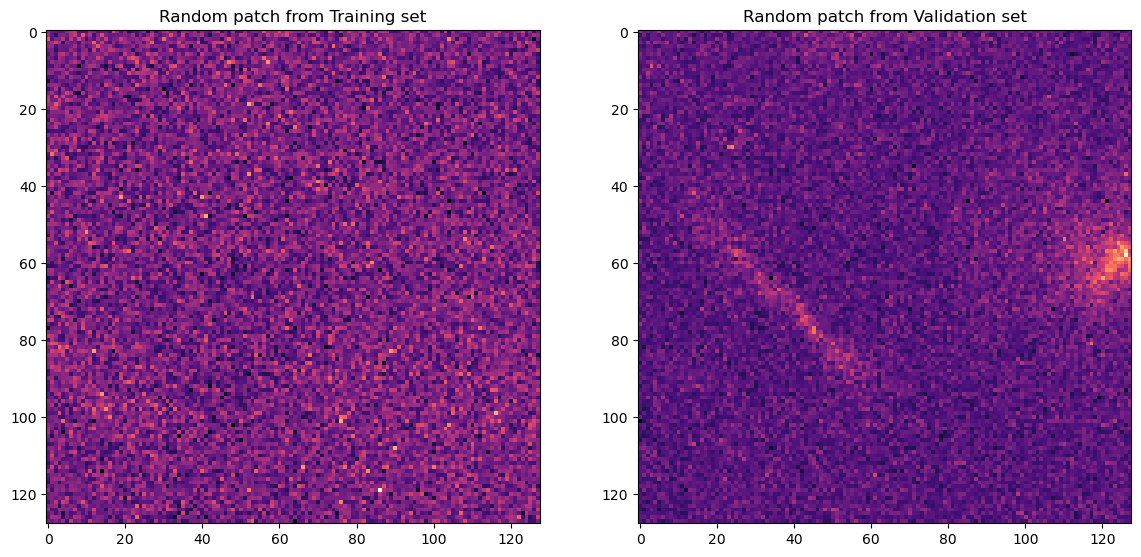

In [44]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(train_patches[7891,...,0], cmap='magma')
plt.title('Random patch from Training set');
plt.subplot(1,2,2)
plt.imshow(val_patches[685,...,0], cmap='magma')
plt.title('Random patch from Validation set');

## Training configuration
- We kept this configuration almost exactly like the examples (other microsopy examples)
- Train_loss, n2v_perc_pix (number of pixels per input patch to be manipulated), n2v_manipulator (how the pixels are sampled in the neighborhood) are all from examples
- Then we set the name of the model and choose where to save it
- Finally we train the model and plot the validation loss

In [50]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch 
# is shown once per epoch. 
config = N2VConfig(train_patches, unet_kern_size=3, 
                   train_steps_per_epoch=int(num_train/batch_size), train_epochs=100, train_loss='mse', batch_norm=True, 
                   train_batch_size=batch_size, n2v_perc_pix=0.198, n2v_patch_shape=patch_shape, 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)


In [51]:
vars(config)

{'means': ['117.19453'],
 'stds': ['9.638828'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 100,
 'train_steps_per_epoch': 340,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (128, 128),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': True,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [52]:
model_name = "n2v_wspa_5_4_23_red_train_v11"
model_dir = path+"\\"+"models"
# initializing the model object
model = N2V(config=config, name=model_name, basedir=model_dir)

C:\ProgramData\Anaconda3\envs\pumps_pycro_tf\lib\site-packages\n2v\models\n2v_standard.py:429: UserWarning: output path for model already exists, files may be overwritten: C:\Users\LevineLab\Documents\python notebooks\Wspa_EXPERIMENT_6_4_23\models\n2v_wspa_5_4_23_red_train_v11
  warnings.warn(


In [53]:
history = model.train(train_patches, val_patches)

32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████████████████████████████████████████| 6218/6218 [00:05<00:00, 1241.53it/s]


Epoch 1/100
340/340 [==============================] - 158s 462ms/step - loss: 0.6362 - n2v_mse: 0.6362 - n2v_abs: 0.6193 - val_loss: 0.6049 - val_n2v_mse: 0.6050 - val_n2v_abs: 0.6074 - lr: 4.0000e-04
Epoch 2/100
340/340 [==============================] - 156s 458ms/step - loss: 0.5883 - n2v_mse: 0.5883 - n2v_abs: 0.6007 - val_loss: 0.5790 - val_n2v_mse: 0.5792 - val_n2v_abs: 0.5982 - lr: 4.0000e-04
Epoch 3/100
340/340 [==============================] - 157s 460ms/step - loss: 0.5856 - n2v_mse: 0.5856 - n2v_abs: 0.6000 - val_loss: 0.5793 - val_n2v_mse: 0.5794 - val_n2v_abs: 0.5975 - lr: 4.0000e-04
Epoch 4/100
340/340 [==============================] - 155s 456ms/step - loss: 0.5819 - n2v_mse: 0.5819 - n2v_abs: 0.5986 - val_loss: 0.5768 - val_n2v_mse: 0.5769 - val_n2v_abs: 0.5973 - lr: 4.0000e-04
Epoch 5/100
340/340 [==============================] - 154s 454ms/step - loss: 0.5824 - n2v_mse: 0.5824 - n2v_abs: 0.5990 - val_loss: 0.5755 - val_n2v_mse: 0.5757 - val_n2v_abs: 0.5961 - lr: 4

Epoch 54/100
340/340 [==============================] - 153s 451ms/step - loss: 0.5751 - n2v_mse: 0.5751 - n2v_abs: 0.5958 - val_loss: 0.5732 - val_n2v_mse: 0.5734 - val_n2v_abs: 0.5957 - lr: 2.0000e-04
Epoch 55/100
340/340 [==============================] - 153s 451ms/step - loss: 0.5751 - n2v_mse: 0.5751 - n2v_abs: 0.5958 - val_loss: 0.5729 - val_n2v_mse: 0.5731 - val_n2v_abs: 0.5944 - lr: 2.0000e-04
Epoch 56/100
340/340 [==============================] - 153s 451ms/step - loss: 0.5752 - n2v_mse: 0.5752 - n2v_abs: 0.5955 - val_loss: 0.5734 - val_n2v_mse: 0.5736 - val_n2v_abs: 0.5957 - lr: 2.0000e-04
Epoch 57/100
340/340 [==============================] - 153s 451ms/step - loss: 0.5752 - n2v_mse: 0.5752 - n2v_abs: 0.5960 - val_loss: 0.5731 - val_n2v_mse: 0.5733 - val_n2v_abs: 0.5950 - lr: 2.0000e-04
Epoch 58/100
340/340 [==============================] - ETA: 0s - loss: 0.5742 - n2v_mse: 0.5742 - n2v_abs: 0.5956
Epoch 58: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-

Epoch 80/100
340/340 [==============================] - 153s 451ms/step - loss: 0.5734 - n2v_mse: 0.5734 - n2v_abs: 0.5949 - val_loss: 0.5724 - val_n2v_mse: 0.5726 - val_n2v_abs: 0.5945 - lr: 2.5000e-05
Epoch 81/100
340/340 [==============================] - 153s 451ms/step - loss: 0.5736 - n2v_mse: 0.5736 - n2v_abs: 0.5950 - val_loss: 0.5732 - val_n2v_mse: 0.5734 - val_n2v_abs: 0.5950 - lr: 2.5000e-05
Epoch 82/100
340/340 [==============================] - 153s 451ms/step - loss: 0.5760 - n2v_mse: 0.5760 - n2v_abs: 0.5962 - val_loss: 0.5727 - val_n2v_mse: 0.5729 - val_n2v_abs: 0.5945 - lr: 2.5000e-05
Epoch 83/100
340/340 [==============================] - 153s 451ms/step - loss: 0.5741 - n2v_mse: 0.5741 - n2v_abs: 0.5952 - val_loss: 0.5726 - val_n2v_mse: 0.5728 - val_n2v_abs: 0.5945 - lr: 2.5000e-05
Epoch 84/100
340/340 [==============================] - 153s 451ms/step - loss: 0.5735 - n2v_mse: 0.5735 - n2v_abs: 0.5953 - val_loss: 0.5729 - val_n2v_mse: 0.5731 - val_n2v_abs: 0.5947 - 

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


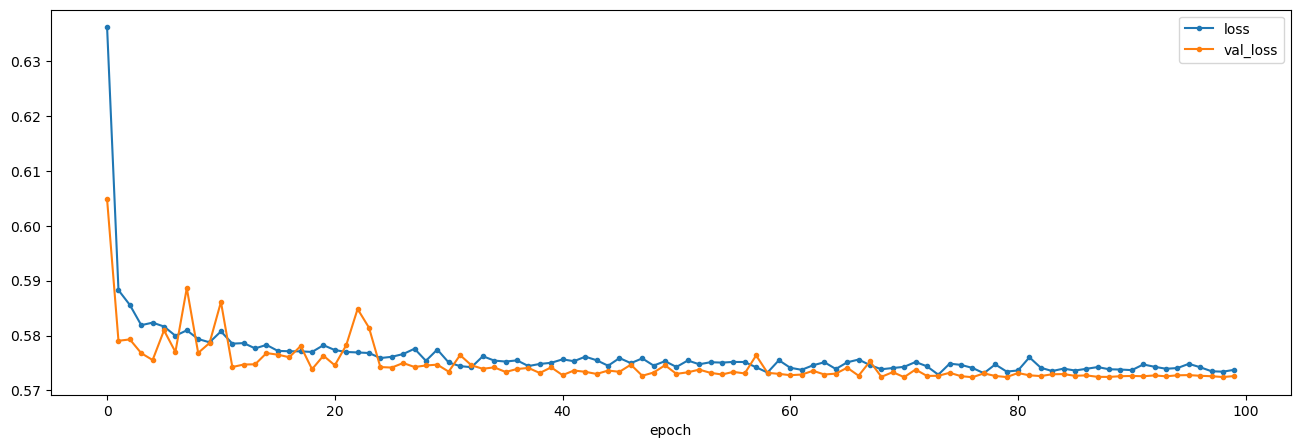

In [54]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Exploring the results
- Here we show random patches from the train and validation set, and their de-noised counterparts

1/1 [==============================] - 0s 19ms/step


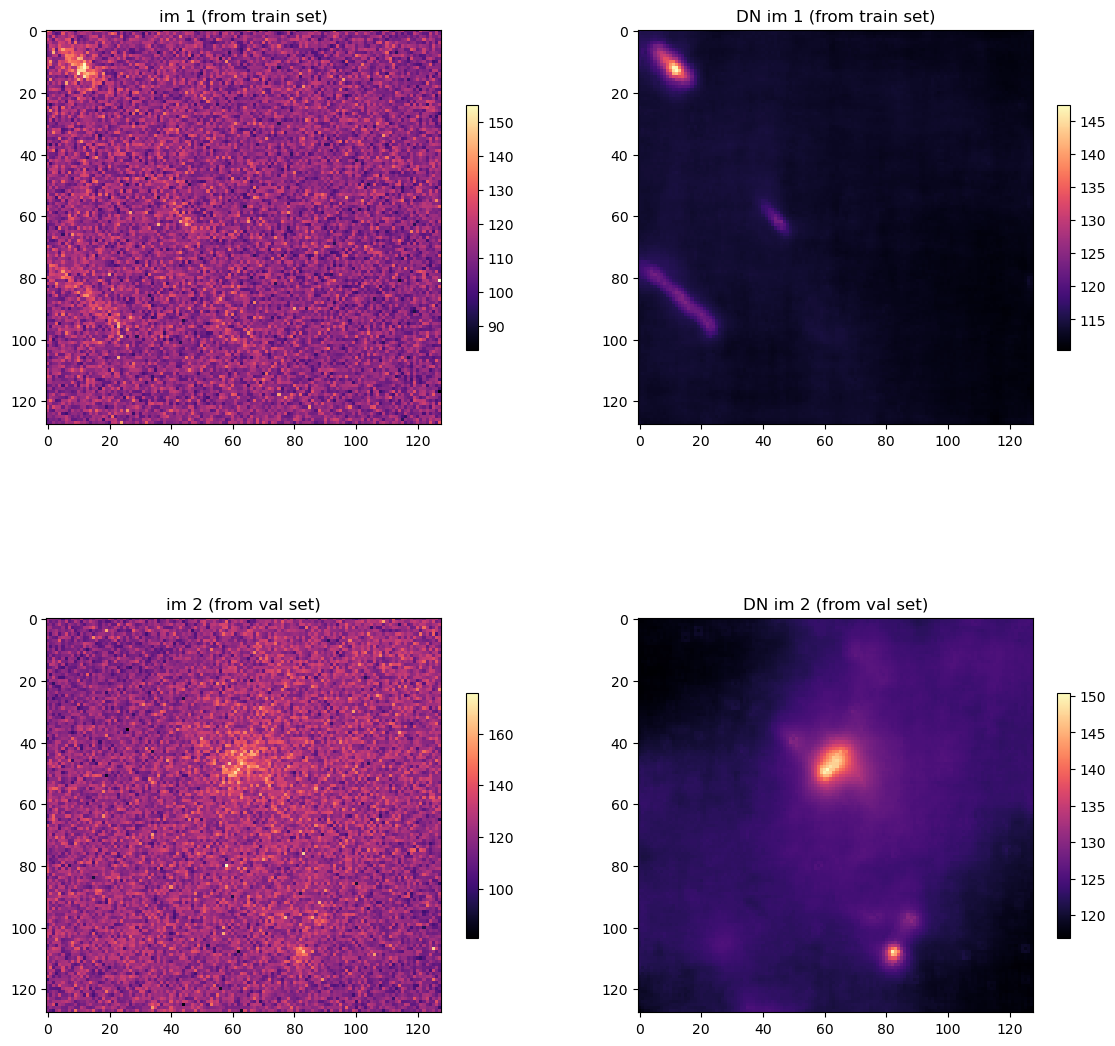

In [69]:
# gg  = np.random.randint(len(val_patches))
# gg2 = np.random.randint(len(val_patches))


plt.figure(figsize=(14,14))
plt.subplot(2,2,2)
plt.imshow(model.predict(train_patches[gg,...,0],'xy'), cmap='magma')
plt.title('DN im 1 (from train set)');
plt.colorbar(shrink = 0.5)

plt.subplot(2,2,1)
plt.imshow(train_patches[gg,...,0], cmap='magma')
plt.title('im 1 (from train set)');
plt.colorbar(shrink = 0.5)


plt.subplot(2,2,4)
plt.imshow(model.predict(val_patches[gg2,...,0],'xy'), cmap='magma')
plt.title('DN im 2 (from val set)');
plt.colorbar(shrink = 0.5)

plt.subplot(2,2,3)
plt.imshow(val_patches[gg2,...,0], cmap='magma')
plt.title('im 2 (from val set)');
plt.colorbar(shrink = 0.5)

1/1 [==============================] - 0s 37ms/step


Text(0, 0.5, 'intensity')

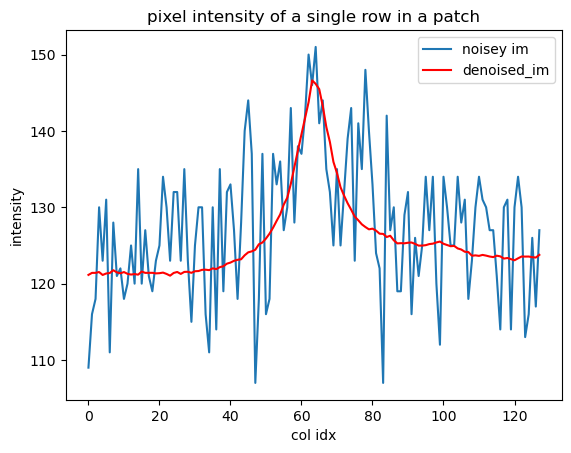

In [123]:
my_slice = val_patches[gg2,...,0][45,:]
plt.plot(np.arange(len(my_slice)),my_slice)

my_slice2 = model.predict(val_patches[gg2,...,0],'xy')[45,:]
plt.plot(np.arange(len(my_slice2)),my_slice2,'red')

plt.title('pixel intensity of a single row in a patch')
plt.legend(['noisey im','denoised_im'])
plt.xlabel('col idx')
plt.ylabel('intensity')

## Artifacts
- In some patches, we noticed some "artifacts" in the denoised version that were not in the noisy version
- However, these emergent patterns appear in patches with no signal
- After plotting the colorbar, the inensity varriation is only a couple pixels
- Therefore, we think this is negligible overall

1/1 [==============================] - 0s 21ms/step


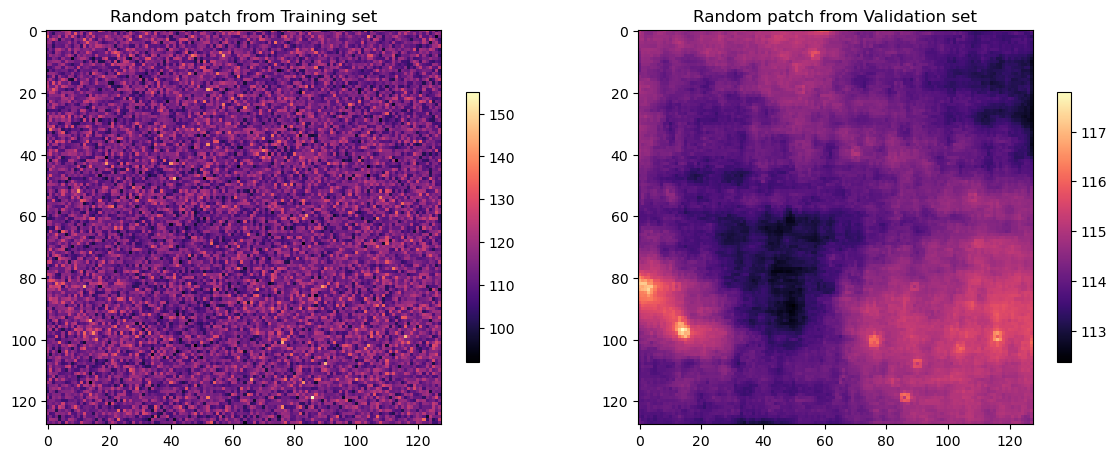

In [72]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(train_patches[7891,...,0], cmap='magma')
plt.title('Random patch from Training set');
plt.colorbar(shrink = 0.5)
plt.subplot(1,2,2)
plt.imshow(model.predict(train_patches[7891,...,0],'xy'), cmap='magma')
plt.title('Random patch from Validation set');
plt.colorbar(shrink = 0.5)

1/1 [==============================] - 0s 21ms/step


Text(0, 0.5, 'intensity')

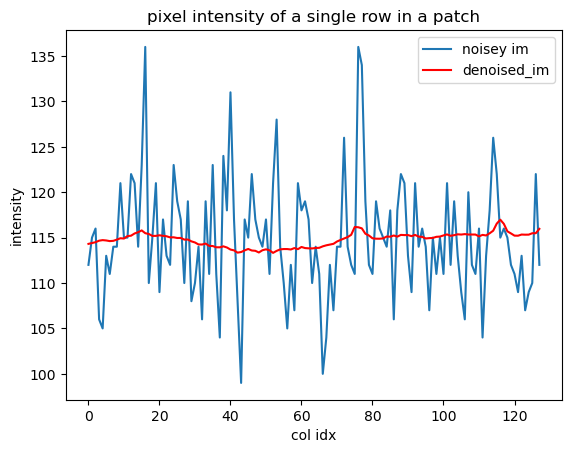

In [77]:
my_slice = train_patches[7891,...,0][100,:]
plt.plot(np.arange(len(my_slice)),my_slice)

my_slice2 = model.predict(train_patches[7891,...,0],'xy')[100,:]
plt.plot(np.arange(len(my_slice2)),my_slice2,'red')

plt.title('pixel intensity of a single row in a patch')
plt.legend(['noisey im','denoised_im'])
plt.xlabel('col idx')
plt.ylabel('intensity')

## Larger patch

1/1 [==============================] - 0s 31ms/step


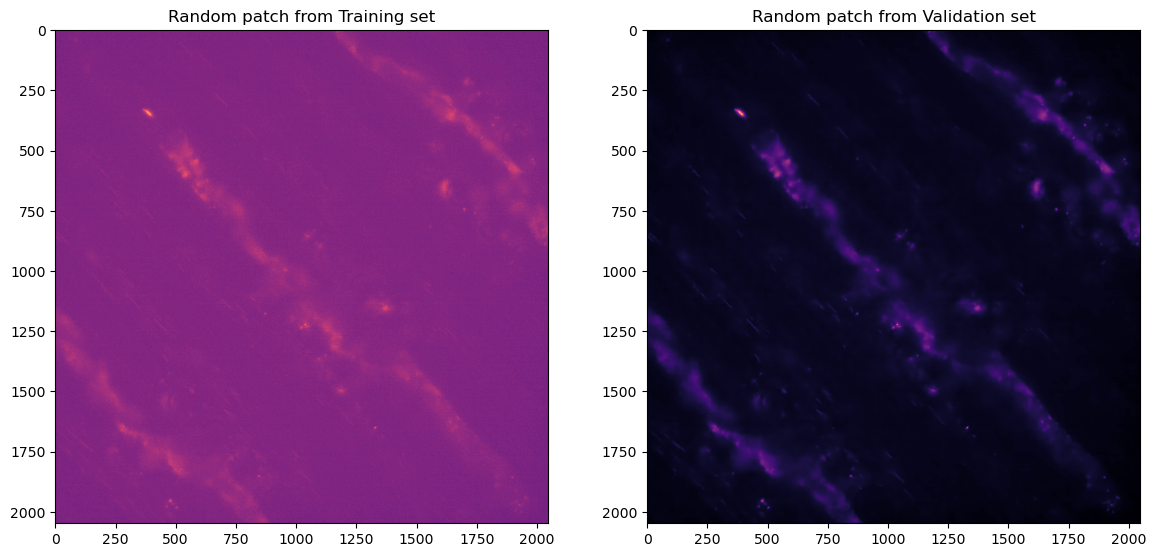

In [60]:
q = 45

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(imgs[q][0,...,0], cmap='magma')
plt.title('Random patch from Training set');
plt.subplot(1,2,2)
plt.imshow(model.predict(imgs[q][0,...,0],'xy'), cmap='magma')
plt.title('Random patch from Validation set');

1/1 [==============================] - 0s 25ms/step


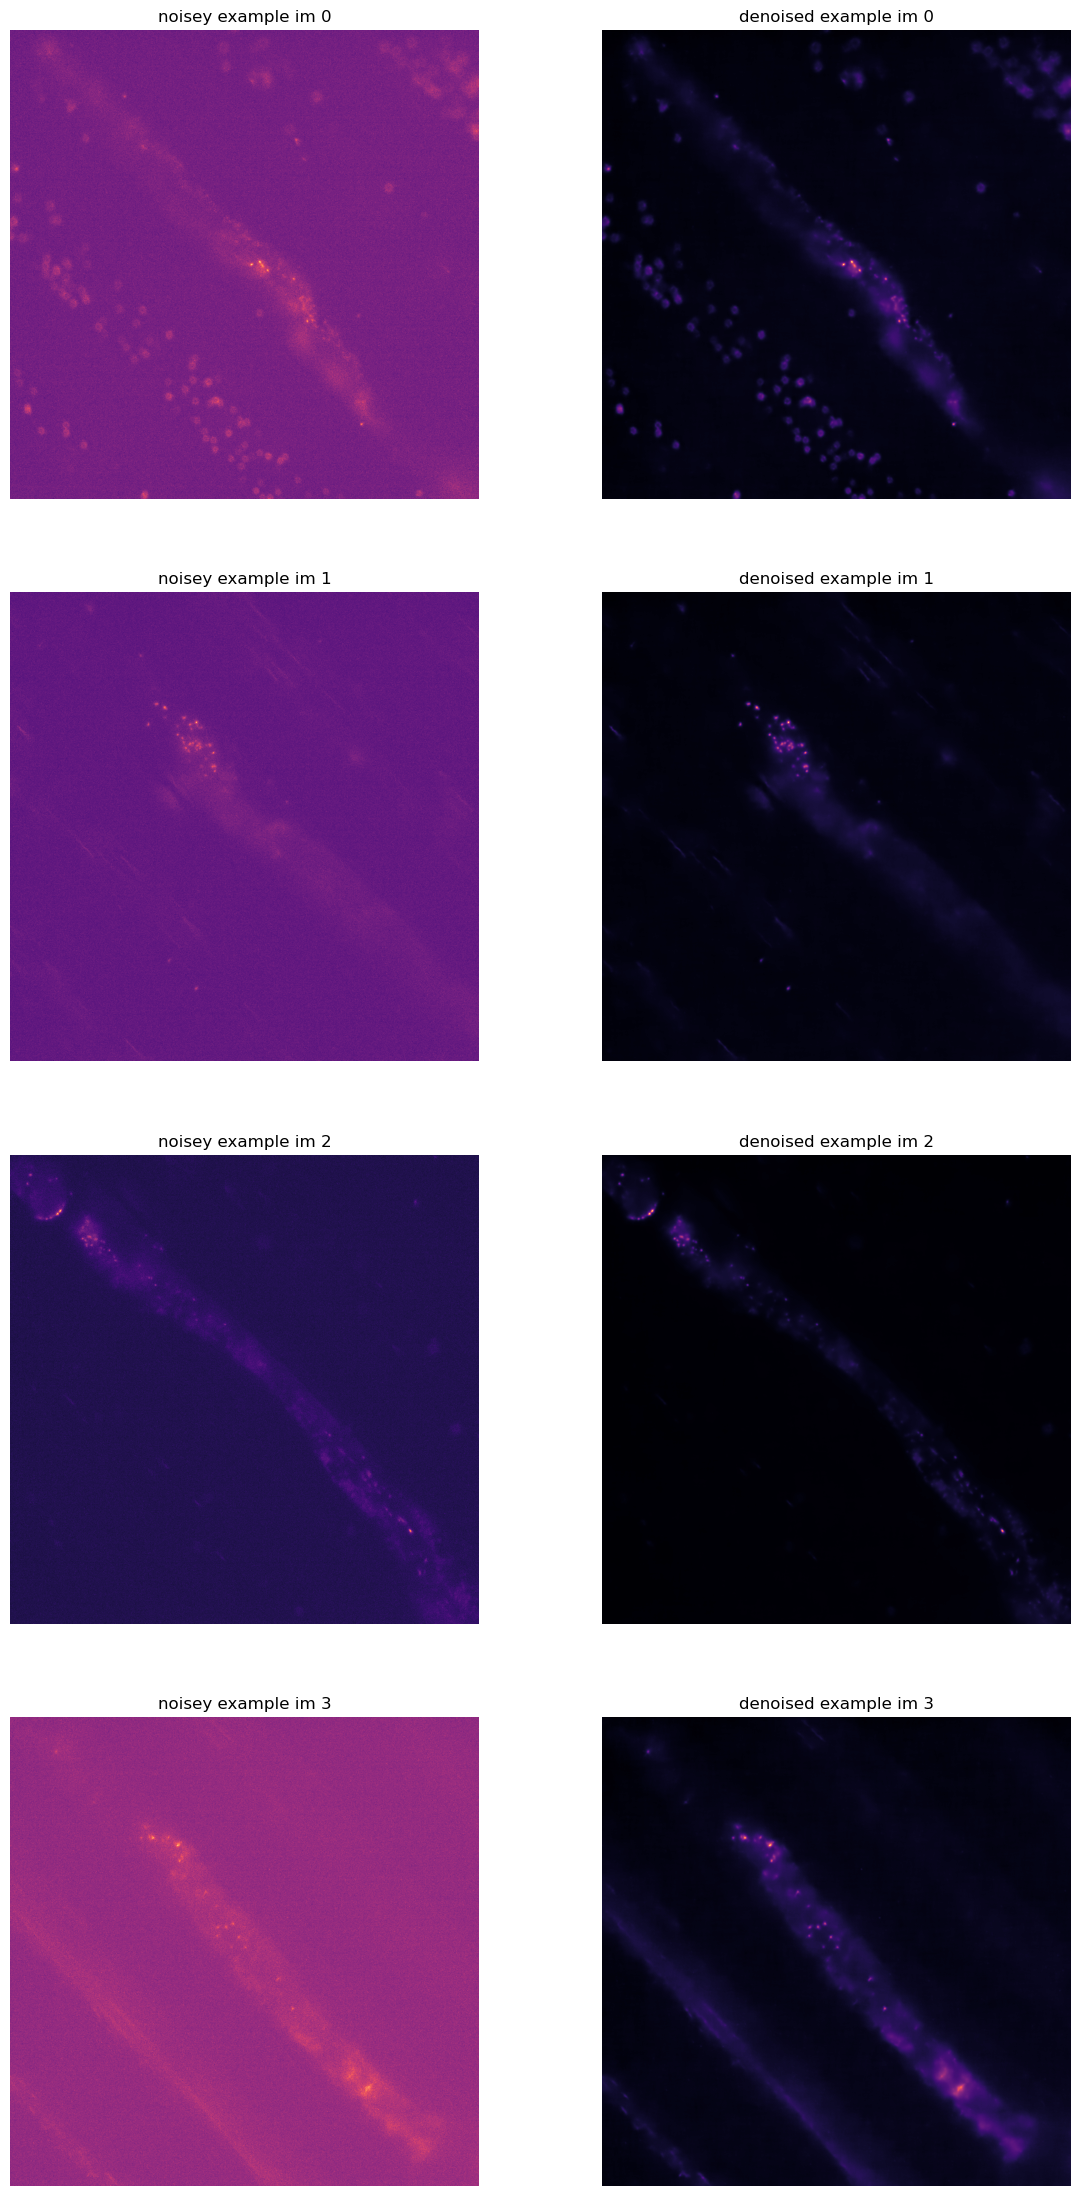

In [121]:
qq = [46, 67, 69, 73]
#q = 80

plt.figure(figsize=(14,7*len(qq)))
for i,q in enumerate(qq):
    
    plt.subplot(len(qq),2,i*2+1)
    plt.imshow(imgs[q][0,:1024,:1024,0], cmap='magma')
    plt.axis(False)
    plt.title(f'noisey example im {i}');
    plt.subplot(len(qq),2,i*2+2)
    plt.imshow(model.predict(imgs[q][0,:1024,:1024,0],'xy'), cmap='magma')
    plt.title(f'denoised example im {i}');
    plt.axis(False)




## Future work
- Explore model params (patch size, num pixel manipulated...)
- Explore model trainig hyper params (batch, epoch,lr, )... we think this wont really have a big impact
- Try with 3-d input (z-stack)
- Try multi channel input
- Quality assesment - currently using "SME" approach, but there are less-biased approaches (currently looking into this)
- Assumptions/eq for "demonstration notebook"
- Wrapper function